In [95]:
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodecsv as csv
import seaborn as sns
import math
from collections import Counter
from cycler import cycler
from textwrap import wrap
from IPython.display import display, HTML, Markdown

In [96]:
%%html
<style>
div.float-bar-whh {
    z-index: 10;
    position: fixed;
    bottom: 5px;
    width: 540px;
    left: 50%;
    right: 50%;
    padding-right: 0px;
    padding-left: 0px;
    margin-left: -270px;
    background: #333;
    opacity: 0.7;
    box-shadow: 0 0 2px 0px black;
}
span.new-name-whh {
    height: 100%;
    line-height: 1em;
    margin: 16px 16px 16px 16px;
    border: none;
    font-size: 146.5%;
    color: white;
    text-overflow: ellipsis;
    overflow: hidden;
    white-space: nowrap;
    border-radius: 2px;
    opacity: 1;
}
</style>

# Original Data Documentation
Refer to records_documentation.txt
- Unique identifier: ID.
- Variable Groups:
    - Column 0-10, profile info; 
    - Column 11-28, employment or education info; (c26 = False or True)
        - Column 11-18, general info;
        - Column 19-25, company info;
        - Column 27-28, school info.

# Aggregate employment changes to the firm-by-date level.

Definition of employment change types: When only employment records are considered, an employment change will be recognized as
- `hiring` if it changed its company to one of the two companies (Deloitte and PwC, hereafter);
- `firing` if it changed its company from one of the two companies to `TIME_OFF` and stayed in `TIME_OFF` for more than 100 days;
- `leaving` if it changed its company from one of the two companies and not recogized as `firing`.

In [97]:
employment_data = "outputs/json_demo.csv"
by_year_data = "outputs/json_demo_by_year.csv"

In [104]:
empl_changes_df

,type,ticker,yrmth,birth,gender,skill1,skill2,cntry,edu,f_elite,edu_faculty,raw_skills,job_role,depmt,ind_next,tenure,nprom,year,month
0,hiring,AMZN,201609.0,1962,2,Software Engineering,Web Development,United States,7,False,"['Engineering', 'Humanities']","['matlab', 'design patterns', 'xml', 'javascri...","['Machine Learning', 'Software Engineer', 'Eng...",['TECHNOLOGY'],NaN,NaN,NaN,2016,9
1,hiring,AMZN,201401.0,1979,2,Software Engineering,Web Development,United States,0,False,[],"['distributed systems', 'scalability', 'ruby',...","['Software Development', 'Development', 'Softw...",['TECHNOLOGY'],NaN,NaN,NaN,2014,1
2,leaving,AMZN,201503.0,1979,2,Software Engineering,Web Development,United States,0,False,[],"['distributed systems', 'scalability', 'ruby',...","['Software Development', 'Development', 'Softw...",['TECHNOLOGY'],48.0,14.0,0.0,2015,3
3,hiring,AMZN,201812.0,1992,0,Software Engineering,Web Development,Canada,4,False,['Engineering'],"['business planning', 'javascript', 'verilog',...","['Software Engineer', 'Engineer']",['TECHNOLOGY'],NaN,NaN,NaN,2018,12
4,hiring,AMZN,201407.0,1993,2,Software Engineering,NaN,India,0,False,['Engineering'],"['software development', 'android', 'java', 'p...","['Software Development', 'Level', 'Engineer', ...",['TECHNOLOGY'],NaN,NaN,NaN,2014,7
5,leaving,AMZN,201412.0,1993,2,Software Engineering,NaN,India,0,False,['Engineering'],"['software development', 'android', 'java', 'p...","['Software Development', 'Level', 'Engineer', ...",['TECHNOLOGY'],54.0,5.0,0.0,2014,12
6,hiring,AMZN,201410.0,1981,0,Software Engineering,CRM and Sales Management,United States,4,True,['Engineering'],"['windows azure', 'google cloud platform', 'an...","['Software Development', 'Engineer', 'Developm...",['TECHNOLOGY'],NaN,NaN,NaN,2014,10
7,leaving,AMZN,201605.0,1981,0,Software Engineering,CRM and Sales Management,United States,4,True,['Engineering'],"['windows azure', 'google cloud platform', 'an...","['Software Development', 'Engineer', 'Developm...",['TECHNOLOGY'],452111.0,19.0,0.0,2016,5
8,hiring,AMZN,201703.0,1988,0,Software Engineering,NaN,United States,5,True,['Engineering'],"['microsoft office', 'leadership', 'speech rec...","['Software Engineer', 'Engineer']",['TECHNOLOGY'],NaN,NaN,NaN,2017,3
9,hiring,AMZN,201608.0,1994,0,Software Engineering,Data Analysis,India,4,False,['Engineering'],"['r', 'machine learning', 'leadership', 'pytho...","['Software Development', 'Engineer', 'Developm...",['TECHNOLOGY'],NaN,NaN,NaN,2016,8


In [98]:
empl_changes_df = pd.read_csv(employment_data) 
empl_by_years = pd.read_csv(by_year_data)

# Summarize and plot.

In [99]:
# Styles 
line_styles = ['-', '--', '-', 'bo-','b^--','b^-','ro-','r^--','r^-']
color_styles = ['skyblue','b','dodgerblue','m','r','salmon']
# Styles for tickers? 
color_styles_2 = ['b','r']
xlefts = [1990]

empl_changes_df['year'] = empl_changes_df['yrmth'].astype(pd.Int32Dtype()) // 100
empl_changes_df['month'] = empl_changes_df['yrmth'].astype(pd.Int32Dtype()) % 100
if 'banks_small' in employment_data:
    empl_changes_df['ticker'] = 'All'
    empl_by_years['ticker'] = 'All'
numtickers = len(empl_changes_df.ticker.unique())

## Count the number of employed accountants from Dec., 1989 on.

Note: 
- This block counts the number of currently employed accountants for the two firms by calculating the cumulative sums of the net employment increase, that is, hiring minus the sum of firing and leaving.
- This method is not effective for the early years. However, if we can assure that we have all the resumes of accountants after some time, we will have the correct number after all the accountants employed before that time have left the company. We assume that the number is correct after 1989 except the most recent years.
- All the numbers are counted in the end of the year and will be used to calculate the proportion of the employment changes for next year. Note that we do not calculate monthly employment separately since there are a good proportion of our data with invalid months.

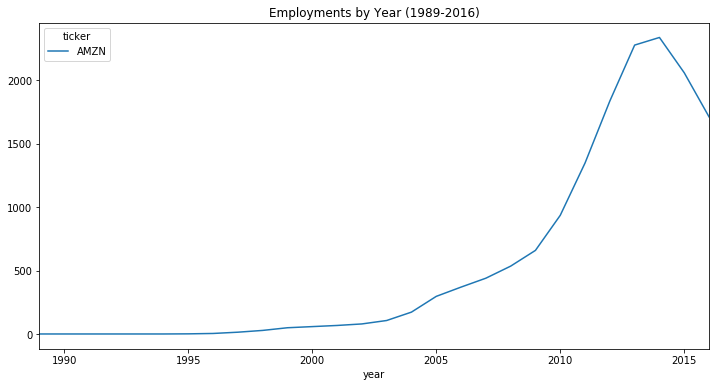

In [100]:
empl_by_years.pivot_table(
    index='year',columns='ticker',values='employment'
).loc[lambda df:(df.index>=1989)&(df.index<=2016)].plot(
    figsize=(12,6),title="Employments by Year (1989-2016)"
)
plt.show()

## Overall trends.
Note: Plots by year and plots by months do not only differ in frequency, but also in sample size. This is due to the entries without valid month record.

In [101]:
prop_by_months = pd.DataFrame(
    {'count':empl_changes_df.groupby(['ticker','type','year','month']).size()} # Count by month.
).reset_index().merge(
    right=empl_by_years.assign(year_1L=lambda df:df.year+1)[['ticker','year_1L','employment']],
    left_on = ['ticker','year'], right_on = ['ticker','year_1L'] # Merge with last year's employment.
).assign(
    prop=lambda df:df['count']/df['employment']*100 # Calculate proportions.
).drop(
    ['count','year_1L','employment'],axis=1 # Drop unnecessary variables.
).loc[lambda df:(df.year>=1990)&(df.year<=2016)] # Keep only [1990, 2016] segment.

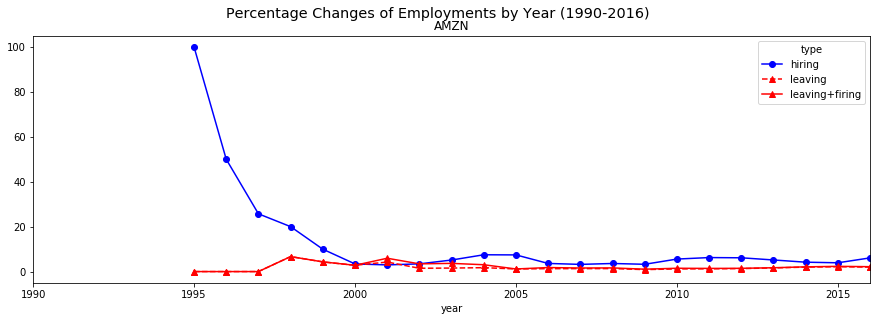

In [102]:
# Count and calculate percentages of employment changes.
prop_by_months = pd.DataFrame(
    {'count':empl_changes_df.groupby(['ticker','type','year','month']).size()} # Count by month.
).reset_index().merge(
    right=empl_by_years.assign(year_1L=lambda df:df.year+1)[['ticker','year_1L','employment']],
    left_on = ['ticker','year'], right_on = ['ticker','year_1L'] # Merge with last year's employment.
).assign(
    prop=lambda df:df['count']/df['employment']*100 # Calculate proportions.
).drop(
    ['count','year_1L','employment'],axis=1 # Drop unnecessary variables.
).loc[lambda df:(df.year>=1990)&(df.year<=2016)] # Keep only [1990, 2016] segment.
prop_by_months = prop_by_months.replace(np.inf, np.nan).dropna(subset=["prop"], how="all")

# Plot by year.
fig, axs = plt.subplots(2,math.ceil(numtickers / 2),figsize=(15,10))
axs = axs.reshape(2, math.ceil(numtickers / 2))
fig.suptitle("Percentage Changes of Employments by Year (1990-2016)", fontsize="x-large",y=0.92)
for (ticker, grp), ax in zip(
    prop_by_months.pivot_table(
        index = ['ticker','year'], columns = 'type', values = 'prop', fill_value=0
    ).reset_index().assign(
        **{"leaving+firing":lambda df:df.leaving+df.firing}
    ).drop("firing",axis=1).groupby('ticker'),
    itertools.chain.from_iterable(axs)):
    grp.drop('ticker',axis=1).loc[lambda df:df.year>=1990].set_index('year').plot(
        ax=ax, title=ticker, xticks=[1990,1995,2000,2005,2010,2015], xlim=(1990,2016), style=['b-o','r--^','r-^']
    )
if numtickers == 1:
    fig.delaxes(axs[1][0])
plt.show()

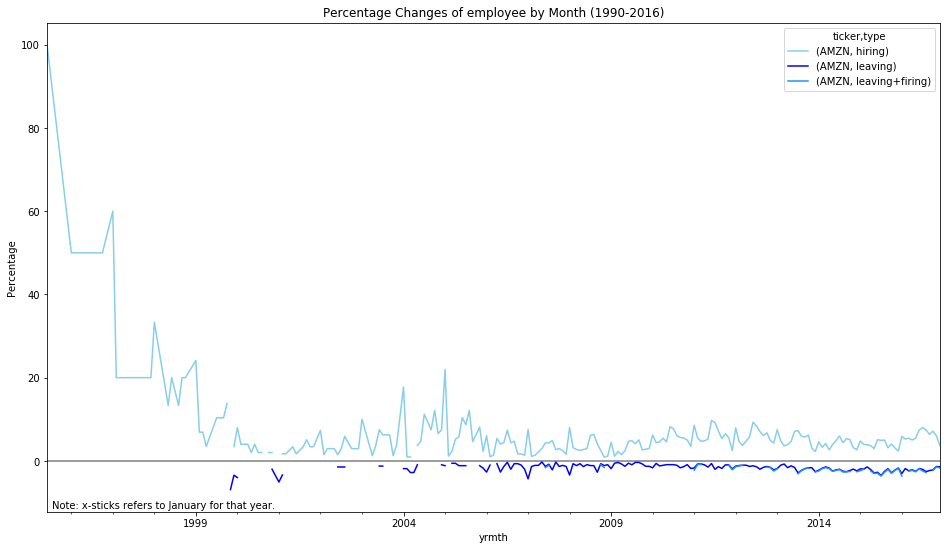

AttributeError: 'DataFrame' object has no attribute 'firing'

In [103]:
# Plot by month.
## Define a routine for plotting over segments.
def plot_by_month(start_year=1990,end_year=2016):
    prop_by_months.loc[lambda df:(df.month!=0)&(df.year>=start_year)&(df.year<=end_year)].pivot_table(
        index = ['ticker','year','month'], columns='type', values = 'prop'
    ).reset_index().assign(
        **{
            "leaving+firing":lambda df:-(df.leaving+df.firing),
            "leaving":lambda df:-df.leaving,
            "yrmth":lambda df:pd.PeriodIndex(year=df.year,month=df.month,freq='M')
        }
    ).pivot_table(
        index='yrmth', columns='ticker', values=['hiring','leaving','leaving+firing']
    ).reorder_levels(
        ['ticker','type'],axis=1
    ).sort_index(axis=1).plot(
        style=color_styles, figsize=(16,9), 
        title="Percentage Changes of employee by Month ({}-{})".format(start_year,end_year)
    ).set_ylabel('Percentage')
    plt.hlines(0,pd.Period('{}-01'.format(start_year)),pd.Period('{}-12'.format(end_year)),colors='tab:gray')
    plt.annotate("Note: x-sticks refers to January for that year.",(5,3),xycoords="axes points")
    plt.show()

    
plot_by_month() # Plot by month over the whole timespan.
plot_by_month(1995,1999) # An example for plotting by month over 1995-1999.


In [ ]:
# Month composition.
display(HTML("<center><strong>Month Composition (-1: None, 0: Invalid month)</strong></center>"))
for idx, grp in empl_changes_df.groupby(['ticker']):
    grp.assign(count=1).pivot_table(
        index = 'month', columns = 'type', values='count', aggfunc='sum', fill_value=0
    ).plot.bar(figsize=(15,5),title=idx).set_ylabel("Count")
    plt.show()

## By birth group.
Note: Birth year `2000` seems to be a trash bin for problematic records and thus will be treated the same as `None`.

In [ ]:
birth_df = empl_changes_df[['ticker','type','year','birth']]
birth_df = birth_df.assign(
    birth = lambda df:df.birth.apply(lambda x:int(x) if x not in ['2000','None'] else np.nan),
    age = lambda df:(df.year-df.birth)
)

# Define a routine to generate plots.
var, xlim = "birth", (1930,2000)
for ticker, grp in birth_df.groupby('ticker'):
    plt.subplots(1,2,figsize=(15,3))
    plt.subplot(121)
    to_plot = grp.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(grp.loc[~grp[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="{} composition".format(var),color=color,legend=True)
    plt.show()
var, xlim = "age", (10,75)
for ticker, grp in birth_df.groupby('ticker'):
    plt.subplots(1,2,figsize=(15,3))
    plt.subplot(121)
    to_plot = grp.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(grp.loc[~grp[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="{} composition".format(var),color=color,legend=True)
    plt.show()

In [ ]:
# Age changes by year.
for (ticker, grp) in birth_df.groupby('ticker'):
    fig, ((ax11, ax12), (ax21, ax22))=plt.subplots(2,2,figsize=(15,10))
    fig.suptitle('Age Changes by Year (1990-2016) - {}'.format(ticker),fontsize='x-large',y=0.95)
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='median'
    ).plot(xlim=(1990,2016),ylim=(20,50),color=color_styles,ax=ax11,title='median')
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='mean'
    ).plot(xlim=(1990,2016),ylim=(20,50),color=color_styles,ax=ax12,title='mean')
    grp.loc[empl_changes_df.gender==1].pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='mean'
    ).plot(xlim=(1990,2016),ylim=(20,50),color=color_styles,ax=ax21,title='mean - female')
    grp.loc[empl_changes_df.gender==2].pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='mean'
    ).plot(xlim=(1990,2016),ylim=(20,50),color=color_styles,ax=ax22,title='mean - male')
    plt.show()

In [ ]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
fig, axs = plt.subplots(numtickers * 3,1,figsize=(13.5,numtickers * 12))
fig.suptitle("Age Group Changes by Year (1990-2016)", fontsize='x-large')
for (idx, grp), ax in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','age']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=pd.cut(grp.age, bins, right=False, labels=False), values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),
        color=[colormap_unif[int(float(i))] for i in to_plot.columns]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title='age'
    )
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## By Gender.

Gender availaibility graph shows the proportion of gender data that was reported / inferred. 

In [ ]:
for ticker, grp in empl_changes_df.replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
).groupby('ticker'):
    fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='gender',
        aggfunc=lambda x:((x==1).sum()/(x==2).sum() if (x==2).sum() else np.nan)
    ).plot(
        xlim=(1990,2016),color=color_styles,title=ticker + ", Female-to-Male Ratio Changes",ax=ax1,
        xticks=[1990+5*x for x in range(6)]
    )
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='gender',
        aggfunc=lambda x:((x!=0).sum()/x.size)
    ).plot(
        xlim=(1990,2016),color=color_styles,title=ticker + ", Gender Availability Changes",ax=ax2,
        xticks=[1990+5*x for x in range(6)]
    )
    plt.show()

In [ ]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
fig, axs = plt.subplots(numtickers * 3,1,figsize=(15,numtickers * 12))
fig.suptitle("Age-Gender Group Changes by Year (1990-2016)", fontsize='x-large')
fig.text(0.25, 0.95,
         "Only for those with gender info available. The lighter color for female, and the deeper color for male.")
for (idx, grp), ax in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(empl_changes_df.gender!=0), ['ticker','type','year','age']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=[pd.cut(grp.age, bins, right=False, labels=False), empl_changes_df.gender], 
        values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),
        color=[
            colormap_unif[int(float(i))] if j==1 else tuple(t/1.1 for t in colormap_unif[int(float(i))]) 
            for i,j in to_plot.columns
        ]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed([handles[i] for i in range(len(handles)) if i%2==0]), 
        reversed(["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in
            [re.match(r"\((\d+)\.0",labels[i]).group(1) for i in range(len(labels)) if i%2==0]
        ]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## By Secondary Skill.

In [ ]:
skill2_to_plot = empl_changes_df.dropna(subset = ['skill2'])

# Create a uniform colormap for all subplots.
skill2_ord_unif = skill2_to_plot.groupby('skill2').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill2_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(6,1,figsize=(12.5,36))
fig.suptitle("Second Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.9)
for (idx, grp), ax in zip(
    skill2_to_plot.loc[lambda df:df.skill2!=''].loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill2']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        skill2_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill2_ord_unif)}[x] for x in df.skill2
        ], count = 1
    ).pivot_table(
        index='year', columns='skill2_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = skill2_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

In [ ]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}

# Find representative profiles.
for i in range(5):
    display(HTML("<strong>"+skill2_ord_unif[i]+"</strong>"))
    to_plot = skill2_to_plot.assign(edu=lambda df:df.edu.apply(lambda x:edu_lablst[int(x)])).loc[
        lambda df:(df.skill2==skill2_ord_unif[i]),
        ["job_role","depmt","edu","f_elite"]
    ]
    N = to_plot.shape[0]
    # Job role.
    varname = "job_role"
    top10_job_role = pd.DataFrame([v
        for w in to_plot.groupby(varname).size().reset_index().apply(
        lambda x:[[x[varname].split(',')[0].title(),x[0]]]
        #lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N*100).apply(round,ndigits=2)
    ).reset_index(drop=True)#.drop("count",axis=1)
    # Department.
    varname = "depmt"
    to_plot_depmt = to_plot.loc[lambda df:df[varname]!='']
    N_depmt = to_plot_depmt.shape[0]
    top10_depmt = pd.DataFrame([v
        for w in to_plot_depmt.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).replace(
        {varname:{"Tehnology":"Technology"}}
    ).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N_depmt*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Education.
    top10_edu = to_plot.groupby("edu").size().sort_values(ascending=False).apply(
        lambda x:round(x/N*100,2)).rename("prop").reset_index()
    # show.
    display(HTML("<em>Top 10 entries for each variables with proportions:</em>"))
    display(pd.concat([top10_job_role,top10_depmt,top10_edu], axis=1))
    # Some examples.
    to_plot = to_plot.sample(30).assign(
        job_role=lambda df:df.job_role.apply(lambda x:x.split(",")[0])
    )
    display(HTML("<em>Some examples:</em>"))
    display(to_plot)
    

## By Country.

In [ ]:
# Create a uniform colormap for all subplots.
cntry_ord_unif = empl_changes_df.groupby('cntry').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    cntry_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='cntry',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:28]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,rotatelabels=True,
#         color = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()


## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(numtickers * 2,1,figsize=(13.5,numtickers * 12))
fig.suptitle("Nationality Composition Change by Year (1990-2016)", fontsize='x-large')
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','cntry']
    ].dropna(subset = ['cntry']).replace('firing', 'leaving').groupby(['ticker','type']), axs):
    to_plot = grp.assign(
        cntry_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(cntry_ord_unif)}[x] for x in df.cntry
        ], count = 1
    ).pivot_table(
        index='year', columns='cntry_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = cntry_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(labels), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
fig, axs = plt.subplots(numtickers * 2,1,figsize=(13.5, numtickers * 12))
fig.suptitle("Nationality Composition Change by Year (1990-2016)", fontsize='x-large')
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','cntry']
    ].dropna(subset = ['cntry']).replace('firing', 'leaving').groupby(['ticker','type']), axs
):
    to_plot = grp.assign(
        cntry_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(cntry_ord_unif)}[x] for x in df.cntry
        ], count = 1
    ).pivot_table(
        index='year', columns='cntry_id', values='count', aggfunc='sum', fill_value=0)
    to_plot.columns = cntry_ord_unif[:N_cats]+["Others"]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        title=str(idx).replace("'","")
    )
    ax.set_ylabel("Count")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(labels), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## By Education Level.

In [ ]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}
colormap_unif = {str(idx):clr for idx, clr in zip(
    range(len(edu_lablst)),
    itertools.cycle([plt.get_cmap('Dark2').colors[0]]+list(plt.get_cmap('Set1').colors))
)}
# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='edu',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[edu_lablst[x] for x in range(0,8)]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
fig, axs = plt.subplots(numtickers * 3,1,figsize=(13.5,numtickers * 12))
fig.suptitle("Education Composition Change by Year (1990-2016)", fontsize='x-large')
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','edu']
    ].groupby(['ticker','type']), axs
):
    to_plot = grp.loc[lambda df:[int(x)>=f_none_hidden for x in df.edu]].assign(count = 1).pivot_table(
        index='year', columns='edu', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[str(idx)] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'","")
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), [edu_lablst[int(x)] for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title="Education"
    )
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
for ticker, grp in empl_changes_df.groupby('ticker'):
    grp.loc[lambda df:df.year>=1990].pivot_table(
        index='year',columns=['ticker','type'],values='f_elite',
        aggfunc=lambda x:((x==True).sum()/(x==x).sum()*100)
    ).plot(
        xlim=(1990,2016),
        title= ticker + ", Elite Ratio Changes (1990-2016)",figsize=(16,6)
    )
    ax.set_ylabel('Percentage')
plt.show()

# By Next Industry.

Note: Division of 2-digit NAICS's into industry groups are obtained from [Bureau of Labor Statistics](https://www.bls.gov/iag/tgs/iag_index_naics.htm).

In [ ]:
NAICS2GRP_dict = {
    '11': (1, "Natural Resources and Mining"),
    '21': (1, "Natural Resources and Mining"),
    '23': (2, "Construction"),
    '31': (3, "Manufacturing"),
    '32': (3, "Manufacturing"),
    '33': (3, "Manufacturing"),
    '42': (4, "Trade, Transportation, and Utilities"),
    '44': (4, "Trade, Transportation, and Utilities"),
    '45': (4, "Trade, Transportation, and Utilities"),
    '48': (4, "Trade, Transportation, and Utilities"),
    '49': (4, "Trade, Transportation, and Utilities"),
    '22': (4, "Trade, Transportation, and Utilities"),
    '51': (5, "Information"),
    '52': (6, "Financial Activities"),
    '53': (6, "Financial Activities"),
    '54': (7, "Professional and Business Services"),
    '55': (7, "Professional and Business Services"),
    '56': (7, "Professional and Business Services"),
    '61': (8, "Education and Health Services"),
    '62': (8, "Education and Health Services"),
    '71': (9, "Leisure and Hospitality"),
    '72': (9, "Leisure and Hospitality"),
    '81': (10, "Other Services"),
    '92': (11, "Public Administration"),
    '99': (12, "Unknown/Unclassified"),
    ''  : (12, "Unknown/Unclassified"),
    'MI': (12, "Unknown/Unclassified"),
    '46': (12, "Unknown/Unclassified")
}

# Show the mappings.
pd.DataFrame(
    [[key, value[0], value[1]] for key,value in NAICS2GRP_dict.items()]
).groupby([1,2])[0].apply(lambda ser:', '.join(ser)).reset_index().drop(1,axis=1).rename(
    {2:"Industry group",0:"NAICS2"},axis=1
)

Note: `46` seems to be a wrong NAICS2 code.

In [ ]:
ind_next_lst = sorted(list(set(NAICS2GRP_dict.values())))
colormap_unif = {idx:clr for idx, clr in zip(
    ind_next_lst[:-1], # Assume the last element is "Others".
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif[ind_next_lst[-1]] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(1,2,figsize=(15,7.5))
# for (idx,col),ax in zip(empl_changes_df.loc[lambda df:df.type=='leaving'].pivot_table(
#     index=empl_changes_df.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
#     columns='ticker', values='gender', aggfunc='count'
# ).iteritems(),axs):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[x[1] for x in col.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
fig, axs = plt.subplots(2,1,figsize=(13.5,12))
fig.suptitle("Next Industry after Leaving Composition Change by Year (1990-2016)", fontsize='x-large', y=0.93)
for (idx, grp), ax in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(df.type=='leaving'), ['ticker','type','year','ind_next']
    ].groupby('ticker'), axs
):
    grp = grp[(grp.ind_next.notnull()) & (grp.ind_next != 'unknown')]
    to_plot = grp.assign(count=1).pivot_table(
        columns=grp.ind_next.apply(lambda x:NAICS2GRP_dict[str(x)[:2]]),
        index='year', values='count', aggfunc='sum', fill_value=0
    )
    if f_none_hidden:
        to_plot.drop(ind_next_lst[-1], axis=1, inplace=True)
    to_plot = to_plot.apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=idx
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["\n".join(wrap(re.match(r"\(\d+, (.+)\)",x).group(1),25)) for x in reversed(labels)], 
        loc='upper left', bbox_to_anchor=(1,1), title="NAICS2 Group"
    )
if numtickers == 1:
    fig.delaxes(axs[1])
plt.show()

## Tenure and Number of Promotions.

Note:
- Tenure = End date of last entry - Start date of first entry in a consecutive sequence of entries in the same company;
 - When there is any invalid month in the two dates and their years are _not_ the same, the invalid month is replaced by 6;
 - When there is any invalid month in the two dates and their years are the same, the invalid month is assumed to be the extreme value (0 for start and 12 for end) and the results are the minimum of their difference and 6.
- Number of promotions = Number of entries in a consecutive sequence of entries in the same company - 1.

In [ ]:
for ticker, grp in empl_changes_df.groupby('ticker'):
    # Calculate.
    to_plot = grp.loc[lambda df:(df.type!='hiring')&(df.year>=1990)&(df.year<=2016)].astype(
        {'tenure':'Int64','nprom':'Int64'}
    ).pivot_table(
        columns=['ticker'],index='year',values=['tenure','nprom'],aggfunc=np.nanmean
    )

    # Plot.
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    fig.suptitle("Tenure and Promotion Statistics for Those Leaving or Fired in Each Year",fontsize='x-large')
    to_plot['tenure'].plot(
        title="Tenure (Months)",ax=ax1,xticks=[1990,1995,2000,2005,2010,2015],xlim=(1990,2016)
    )
    to_plot['nprom'].plot(
        title="Number of Promotions",ax=ax2,xticks=[1990,1995,2000,2005,2010,2015],xlim=(1990,2016)
    )
plt.show()